## Assignment 1
### Name: Gautam Kumar
### Roll Number: 21CS30020

In [1]:
# import all the necessary libraries here
import pandas as pd
import numpy as np
import math
import graphviz
from IPython.display import Image, display
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler    

In [2]:
df = pd.read_csv('../../dataset/decision-tree.csv')
print(df.shape) 

(768, 9)


In [3]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [4]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [6]:
# Test train Split
frac_1 = 0.8
df = df.sample(frac=1.0).reset_index(drop=True)     
ind = int(len(df.index) * frac_1)
Train = df.iloc[:ind, :].reset_index(drop=True)     
Test = df.iloc[ind:, :].reset_index(drop=True)      

X_train = Train.iloc[:,:-1]
Y_train = Train.iloc[:,-1]
X_test = Test.iloc[:,:-1]
Y_test = Test.iloc[:,-1]


In [7]:
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(614, 8) (614,)
(154, 8) (154,)


In [8]:
prediction = []

In [9]:
#Utils
def split_df_col(df):
    data = df.iloc[:, :-1]
    labels = df.iloc[:, -1]
    return (data, labels)

def entropy(labels):
    total = len(labels)
    diff_vals = labels.value_counts().tolist()
    diff_vals = [-1*(x/total)*math.log2(x/total) for x in diff_vals]
    return sum(diff_vals)



def information_gain(data,labels,attr,split_val):
    filt = data[attr] < split_val
    left_labels = labels[filt]
    right_labels = labels[~filt]
    gain = entropy(labels) -  (len(left_labels) * entropy(left_labels) + len(right_labels) * entropy(right_labels))/len(labels)
    return gain


def find_best_split(data,labels,attr):
    vals = np.sort(data[attr].unique())
    best_gain = 0;
    best_split_val = None
    for i in range(len(vals) - 1):
        split_val = (vals[i] + vals[i + 1])/2
        gain = information_gain(data,labels,attr,split_val)
        if best_gain < gain:
            best_gain = gain
            best_split_val = split_val
    return (best_split_val,best_gain)

def get_pred_accuracy(tree,test):
    test_data,test_labels = split_df_col(test)
    preds = tree.predict(test_data)
    accuracy = np.mean(preds == test_labels)*100
    return accuracy
# def get_accuracy_list(tree,root,data):
#     if root.is_leaf():
#         return
#     get_accuracy_list(tree,root.left,data)
#     get_accuracy_list(tree,root.right,data)
#     left,right = root.left,root.right
#     root.left = None
#     root.right = None
#     predict = get_pred_accuracy(tree,data)
#     prediction.append(predict)
#     root = root_temp
#     return

    

For finding the Accuracy, i did it inside the Prunning function.

In [10]:
class Node:
    def __init__(self, attr,split_val,prob_label):
        self.attr = attr
        self.split_val = split_val
        self.prob_label = prob_label
        self.left = None
        self.right = None
    def is_leaf(self):
        return (self.left == None) and (self.right == None)
    def node_count(self):
        left_count,right_count = 0,0
        if self.left != None:
            left_count = self.left.node_count()
        if self.right != None:
            right_count = self.right.node_count()
        return 1 + left_count + right_count
    def prune(self,tree,accuracy,valid,pred = False):
        new_acc = 0
        
        if self.left == None and self.right==None:
            return accuracy
            
        if self.left != None:
            new_acc = self.left.prune(tree,accuracy,valid,pred)
        if self.right != None:
            new_acc = self.right.prune(tree,accuracy,valid,pred)
            
        left,right = self.left,self.right
        self.right = None
        self.left = None
        temp_acc = get_pred_accuracy(tree,valid)
        
        if pred == True:
            prediction.append(temp_acc)
            self.left,self.right = left,right
            return temp_acc
        
        if temp_acc < new_acc or tree.root.node_count() <= 5:
            self.left,self.right = left,right
        else:
            new_acc = temp_acc
            self.attr = 'Outcome'
        return new_acc
    def format_string(self):
        if self.is_leaf():
            outcome = 'Yes' if self.prob_label == 1 else 'No'
            return f'{self.attr}\n{outcome}'
        else:
            if self.attr == 'DiabetesPedigreeFunction':
                return f'{self.attr} <\n {self.split_val:.4f}'
            elif self.attr == 'BMI':
                return f'{self.attr} < {self.split_val:.4f}'
            else:
                return f'{self.attr} < {self.split_val}'

In [11]:
class DecisionTree:
    def __init__(self,max_depth = 10,min_sample = 10):
        self.root = None
        self.max_depth = max_depth
        self.min_samples = min_sample
        self.tree_depth = 0
        
    def train(self,X_train,Y_train):
        train_data , train_labels = X_train,Y_train
        self.root = self.built_tree(train_data,train_labels)
    
    def built_tree(self,train_data,train_labels,depth = 0):
        if (depth >= self.max_depth) or (len(train_data) <= self.min_samples) or (len(train_labels.unique()) == 1):
            return self.create_leaf(train_labels)
        
        attr,split_val = self.get_best_attribute(train_data,train_labels)
        node = Node(attr,split_val,train_labels.value_counts().idxmax())
        
        mask = train_data[attr] < split_val
        left_data = train_data[mask]
        left_labels = train_labels[mask]
        if split_val == None:
            print(attr,",",len(train_data))
        node.left = self.built_tree(left_data,left_labels,depth + 1)
        
        right_data = train_data[~mask]
        right_labels = train_labels[~mask]
        node.right = self.built_tree(right_data,right_labels,depth+1)
        
        self.tree_depth = max(self.tree_depth,depth)
        return node
    
    def create_leaf(self,train_labels):
        prob_label  =train_labels.value_counts().idxmax()
        node = Node('Outcome',None,prob_label)
        return node
    def get_best_attribute(self,train_data,train_labels):
        attributes = train_data.columns
        max_gain = -10**20
        best_attr = None
        best_split_val = None
        
        for attr in attributes:
            split_val, gain = find_best_split(train_data,train_labels,attr)
            if gain < max_gain and gain < -10**20:
                print(gain)
                
            if gain > max_gain:
                max_gain = gain
                best_attr = attr
                best_split_val = split_val
        return (best_attr,best_split_val)
    
    def predict_one(self,test_data,root):
        if root == None:
            return None
        if root.is_leaf():
            return root.prob_label
        if test_data[root.attr] <= root.split_val:
            return self.predict_one(test_data,root.left)
        else:
            return self.predict_one(test_data,root.right)
    
    def predict(self,test_data):
        predictions = pd.Series([self.predict_one(row,self.root) for row in test_data.to_dict(orient='records')])
        return predictions
    def print_tree(self, file):
        tree = graphviz.Digraph(filename=file, format='png', node_attr={'shape': 'box'})
        root = self.root
        queue = []
        queue.append(root)
        root.id = 0
        tree.node(str(root.id), label=root.format_string())
        uid = 1
        edge_labels = ['True', 'False']
        while(len(queue) > 0):
            node = queue.pop(0)
            for i, child in enumerate([node.left, node.right]):
                if child != None:
                    child.id = uid
                    uid += 1
                    queue.append(child)
                    tree.node(str(child.id), label=child.format_string())
                    tree.edge(str(node.id), str(child.id), label=edge_labels[i])

        tree.render(file, view=True)
        

In [12]:
tree = DecisionTree()
tree.train(X_train,Y_train)

In [13]:
accuracy = get_pred_accuracy(tree,Train)

In [14]:
print(f"The Accuracy on the Train Data ::{accuracy}")

The Accuracy on the Train Data ::90.22801302931596


In [15]:
test_accuracy = get_pred_accuracy(tree,Test)
print(f"The Accuracy on the Test Data ::{test_accuracy}")

The Accuracy on the Test Data ::70.12987012987013


In [16]:
tree.print_tree('before_pruning.gv')
last_accu = tree.root.prune(tree,accuracy,Train,True)

In [17]:
last_accu = tree.root.prune(tree,test_accuracy,Test)

In [18]:
tree.print_tree('after_pruning.gv')

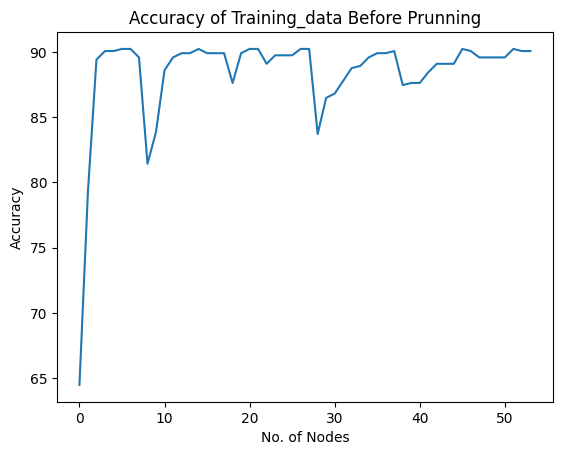

In [19]:

prediction_temp = np.array(prediction)
prediction_temp = np.flip(prediction_temp)
figure, ax1 = plt.subplots()
nums = np.arange(len(prediction_temp))
ax1.plot(nums,np.array(prediction_temp).reshape((len(prediction,))))
ax1.set_xlabel('No. of Nodes')
ax1.set_ylabel('Accuracy')
ax1.set_title('Accuracy of Training_data Before Prunning')
plt.show()

In [20]:
accuracy = get_pred_accuracy(tree,Train)

In [21]:
print(f"Accuracy on Training set after Prunning {accuracy}")

Accuracy on Training set after Prunning 81.43322475570032


In [22]:
prediction.clear()

In [23]:
last_accu = tree.root.prune(tree,accuracy,Train,True)

In [24]:
prediction

[80.78175895765473,
 81.43322475570032,
 81.10749185667753,
 79.31596091205212,
 80.78175895765473,
 76.54723127035831,
 74.1042345276873,
 72.80130293159608,
 64.49511400651465]

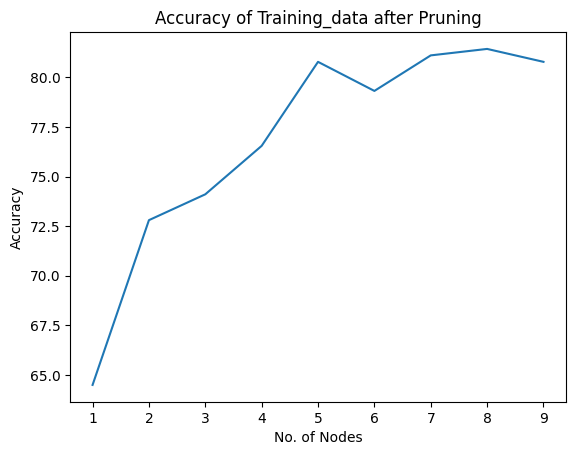

In [25]:
prediction_temp = np.array(prediction)
prediction_temp = np.flip(prediction_temp)
figure, ax1 = plt.subplots()
nums = 1 + np.arange(len(prediction_temp))
ax1.plot(nums,np.array(prediction_temp).reshape((len(prediction,))))
ax1.set_xlabel('No. of Nodes')
ax1.set_ylabel('Accuracy')
ax1.set_title('Accuracy of Training_data after Pruning')
plt.show()

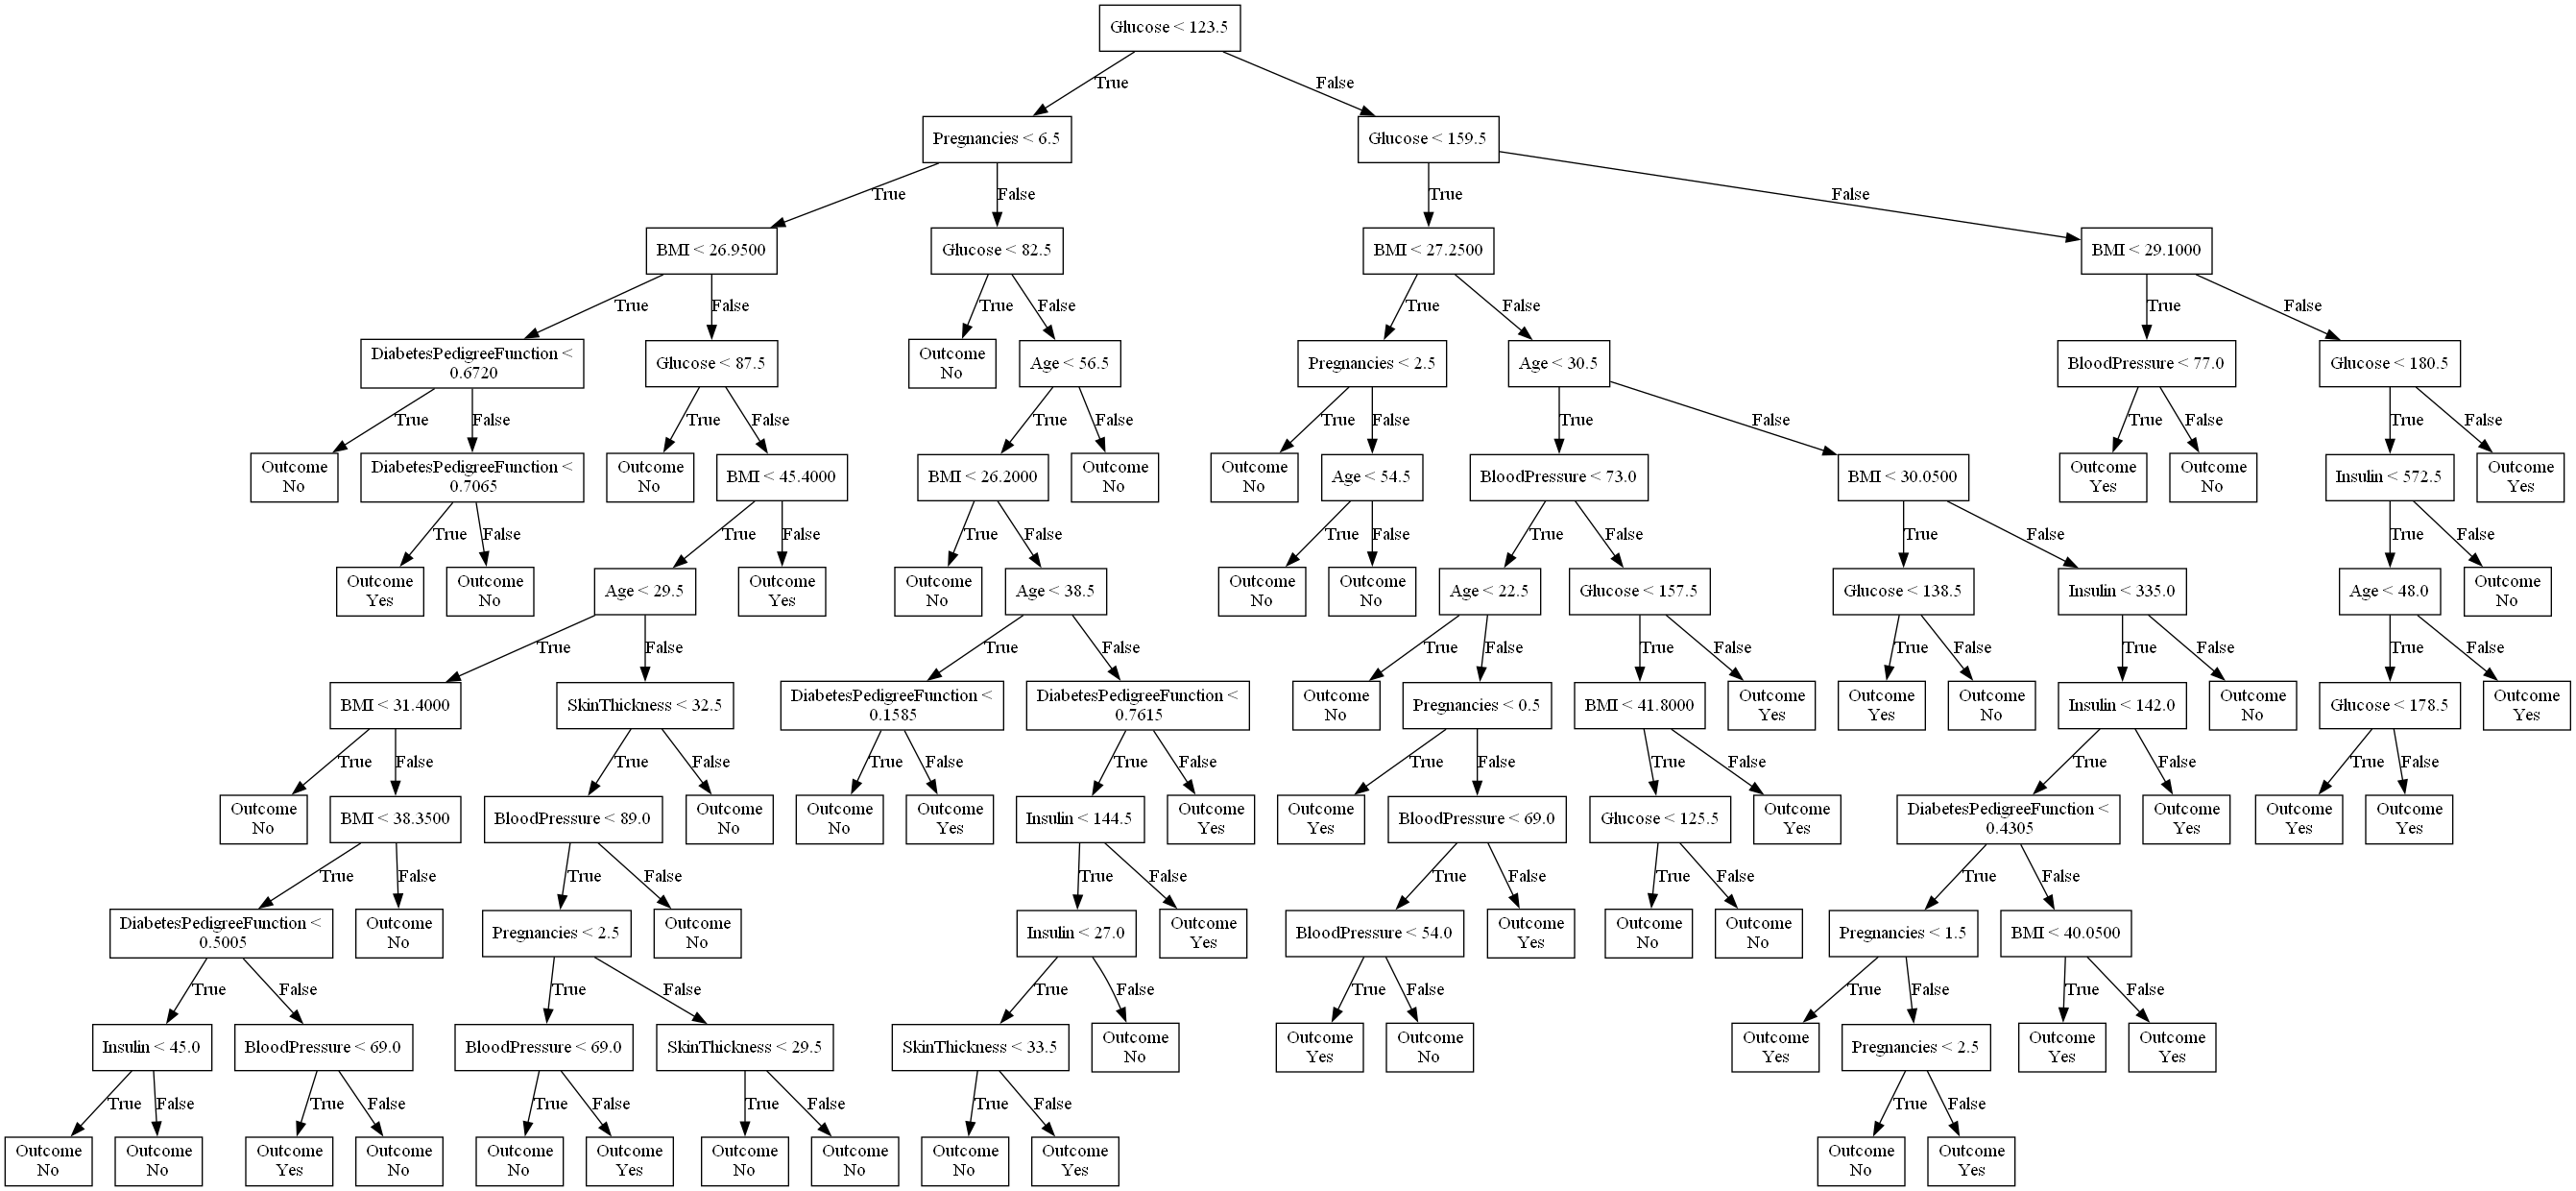

In [26]:
display(Image(filename='before_pruning.gv.png'))

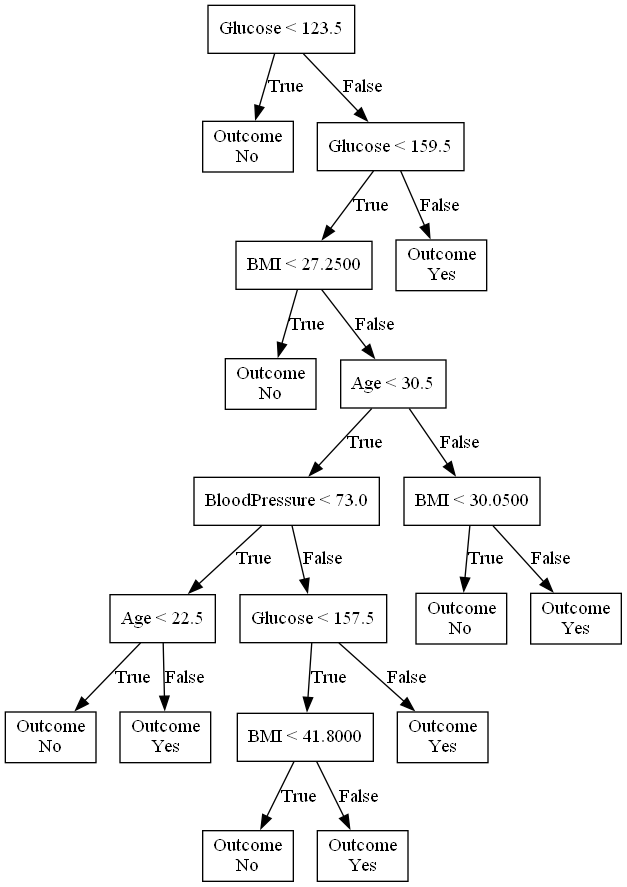

In [27]:
display(Image(filename='after_pruning.gv.png'))